Enter source airport city: Lahore
Enter source airport city: Islamabad
Enter date (yyyy-mm-dd): 2007-01-01
{'route': ['Lahore', 'Lahore', 'Rawalpindi', 'Karachi', 'Quetta', 'Karachi', 'Islamabad'], 'aircraft': 'Aircraft 121', 'total_distance': 12217.83714145099, 'fitness': 955490.306176148}


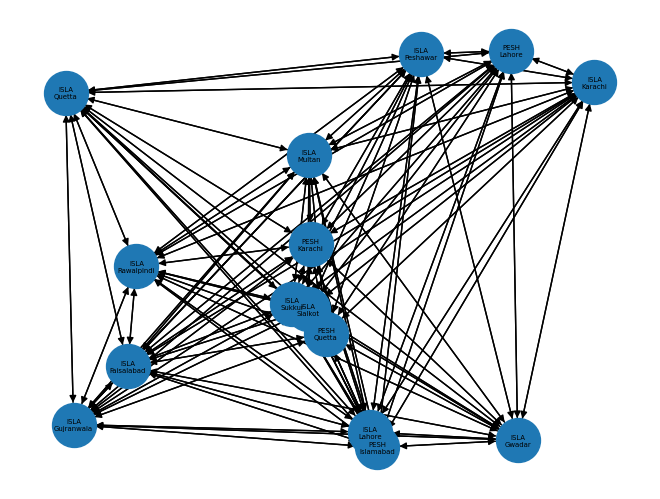

In [4]:
import math
import random
import csv
import networkx
import matplotlib.pyplot as plot


# ==============================================================================================================
# Data storage classes
# ==============================================================================================================


class Aircraft:
    def __init__(self, aircraft_type, maximum_range, cruise_speed, fuel_consumption, icao_code):
        self.aircraft_type = aircraft_type
        self.maximum_range = maximum_range
        self.cruise_speed = cruise_speed
        self.fuel_consumption = fuel_consumption
        self.icao_code = icao_code


class Airport:
    def __init__(self, icao_code, latitude, longitude, city):
        self.icao_code = icao_code
        self.latitude = latitude
        self.longitude = longitude
        self.city = city


class Weather:
    def __init__(self, date, wind_speed, wind_direction, city):
        self.date = date
        self.wind_speed = wind_speed
        self.wind_direction = wind_direction
        self.city = city


# ==============================================================================================================
# Route class, this is the 'individual' or candidate solution in the genetic algorithm population.
# ==============================================================================================================


class Route:
    def __init__(self, date, aircraft, airport_list):
        self.date = date
        self.aircraft = aircraft
        self.airport_list = airport_list

        # (aircraft + airport_list) is the chromosome
        # each airport in the list is a gene
        # the aircraft is an additional gene
        # the date is needed to determine the weather for each airport (on that day)

    def get_evaluation(self, weather_table):
        # find the total distance of this route.
        # if the aircraft can't cover the distance, this route will be discarded.
        total_distance = self.get_total_distance()
        if self.aircraft.maximum_range > total_distance:
            return float('inf')

        # calculate the average speed of the aircraft taking into account the effect of wind
        wind_speed, wind_direction = self.get_average_wind(weather_table)
        wind_impact = wind_speed * math.cos(math.radians(wind_direction))
        total_time = total_distance / (self.aircraft.cruise_speed + wind_impact)
        # the average speed and total distance give us the total time

        # calculate the fuel consumed (with wind effect)
        wind_impact = wind_impact / self.aircraft.cruise_speed
        wind_impact *= self.aircraft.fuel_consumption
        total_fuel = (self.aircraft.fuel_consumption + wind_impact) * total_distance

        # final evaluation (equal weightage to time and fuel)
        # lower values are better (less time and fuel used)
        return (total_time * 0.5) + (total_fuel * 0.5)

    def get_total_distance(self):
        # the distance between two airports is the Euclidean distance of their latitudes and longitudes
        def euclidean_distance(a, b):
            return math.sqrt(((b[0] - a[0]) ** 2) + ((b[1] - a[1]) ** 2))

        distance = 0
        for index, airport in enumerate(self.airport_list[:-1]):
            next_airport = self.airport_list[index + 1]
            source_location = (airport.latitude, airport.longitude)
            target_location = (next_airport.latitude, next_airport.longitude)
            distance += euclidean_distance(source_location, target_location)
        return distance

    def get_average_wind(self, weather_table):
        # the weather table must be keyed by date and then city
        # so the weather on 10th November gives us the weather of all cities on that day
        # then we can select a particular city

        average_speed = sum([weather_table[self.date][airport.city].wind_speed
                             for airport in self.airport_list]) / len(self.airport_list)
        average_direction = sum([weather_table[self.date][airport.city].wind_direction
                                 for airport in self.airport_list]) / len(self.airport_list)
        return average_speed, average_direction


# ==============================================================================================================
# Manager class, will do all the work of reading datasets, generating routes and calling the algorithm.
# ==============================================================================================================

class Manager:
    def __init__(self, aircraft_file, airport_file, weather_file):
        # file paths
        self.aircraft_file = aircraft_file
        self.airport_file = airport_file
        self.weather_file = weather_file

        # datasets converted to lists
        self.aircraft_list = self.read_aircraft_data()
        self.airport_list = self.read_airport_data()
        self.weather_list = self.read_weather_data()

        # each list is converted to a dictionary for simpler access (by id or other keys)

        # dictionary[icao_code, aircraft]
        self.aircraft_table = {}
        for aircraft in self.aircraft_list:
            self.aircraft_table[aircraft.icao_code] = aircraft

        # dictionary[icao_code, dictionary[city, airport]]
        self.airport_table = {}
        for airport in self.airport_list:
            if airport.icao_code not in self.airport_table:
                self.airport_table[airport.icao_code] = {}
            self.airport_table[airport.icao_code][airport.city] = airport

        # dictionary[date, dictionary[city, weather]]
        self.weather_table = {}
        for weather in self.weather_list:
            if weather.date not in self.weather_table:
                self.weather_table[weather.date] = {}
            self.weather_table[weather.date][weather.city] = weather

        # airport graph
        self.airport_graph = networkx.complete_graph(self.airport_list, create_using=networkx.DiGraph())

    def read_aircraft_data(self):
        aircraft_list = []
        with open(self.aircraft_file, 'r', newline='') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                aircraft_type = row['Aircraft Type']
                max_range = float(row['Max Range'])
                cruise_speed = float(row['Cruise Speed'])
                fuel_consumption = float(row['Fuel Consumption at Cruise'])
                icao_code = row['ICAO CODES']
                aircraft = Aircraft(aircraft_type, max_range, cruise_speed, fuel_consumption, icao_code)
                aircraft_list.append(aircraft)
        return aircraft_list

    def read_airport_data(self):
        airport_list = []
        with open(self.airport_file, 'r', newline='') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                icao_code = row['ICAO Code']
                latitude = int(row['Latitude'])
                longitude = int(row['Longitude'])
                city = row['City']
                airport = Airport(icao_code, latitude, longitude, city)
                airport_list.append(airport)
        return airport_list

    def read_weather_data(self):
        weather_list = []
        with open(self.weather_file, 'r', newline='') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                date = row['Date']
                wind_speed = row['Wind Speed']
                wind_direction = row['Wind Direction']
                city = row['City']
                wind_speed = 0.0 if wind_speed == '' else float(wind_speed)
                wind_direction = 0.0 if wind_direction == '' else float(wind_direction)
                weather = Weather(date, wind_speed, wind_direction, city)
                weather_list.append(weather)
        return weather_list

    def get_random_route(self, length=None, date=None):
        route_aircraft = random.randint(0, len(self.aircraft_list) - 1)
        route_length = (random.randint(3, 9) if length is None else length)
        route_airport_list = []
        for _ in range(route_length):
            route_airport = random.choice([airport for airport in range(len(self.airport_list))
                                           if airport not in route_airport_list])
            route_airport_list.append(self.airport_list[route_airport])
        if date is None:
            route_weather = random.randint(0, len(self.weather_list) - 1)
            date = self.weather_list[route_weather].date
        return Route(date, self.aircraft_list[route_aircraft], route_airport_list)

    def save_airport_graph_image(self, file_path, limit):
        airport_graph = self.airport_graph.subgraph(list(self.airport_graph)[:limit])
        positions = {airport: (airport.latitude, airport.longitude) for airport in airport_graph}
        labels = {airport: f"{airport.icao_code}\n{airport.city}" for airport in airport_graph}
        networkx.draw(airport_graph, positions, labels=labels, node_size=1000, font_size=5)
        plot.savefig(file_path)


def main():
    manager = Manager('aircraftDataset.csv', 'airportDataset.csv', 'weatherDataset.csv')
    manager.save_airport_graph_image('airport_graph.png', 15)

    source_airport_icao = random.randint(0, len(manager.airport_list) - 1)
    target_airport_icao = random.randint(0, len(manager.airport_list) - 1)

    source_airport_icao = manager.airport_list[source_airport_icao].icao_code
    target_airport_icao = manager.airport_list[target_airport_icao].icao_code

    source_airport_city = input('Enter source airport city: ')
    source_airport = manager.airport_table[source_airport_icao][source_airport_city]

    target_airport_city = input('Enter source airport city: ')
    target_airport = manager.airport_table[target_airport_icao][target_airport_city]

    date = input('Enter date (yyyy-mm-dd): ')

    chromosome_length = 5
    population_size = 10
    maximum_generations = 100
    individuals = [manager.get_random_route(chromosome_length, date) for _ in range(population_size)]

    for _ in range(maximum_generations):
        generation = []

        for _ in range(population_size // 2):
            parent_1 = min(individuals, key=lambda route: route.get_evaluation(manager.weather_table))
            individuals.remove(parent_1)
            parent_2 = min(individuals, key=lambda route: route.get_evaluation(manager.weather_table))
            individuals.remove(parent_2)

            crossover_point = random.randint(1, chromosome_length - 1)
            child_1 = Route(parent_1.date, parent_1.aircraft, parent_1.airport_list)
            child_2 = Route(parent_2.date, parent_2.aircraft, parent_2.airport_list)
            child_1.airport_list = parent_1.airport_list[:crossover_point] + parent_2.airport_list[crossover_point:]
            child_2.airport_list = parent_2.airport_list[:crossover_point] + parent_1.airport_list[crossover_point:]
            if random.random() < 0.50:
                child_1.aircraft, child_2.aircraft = child_2.aircraft, child_1.aircraft

            mutation_probability = 0.10

            for index in range(len(child_1.airport_list)):
                if random.random() < mutation_probability:
                    airport = random.choice([airport for airport in range(len(manager.airport_list))
                                             if airport not in child_1.airport_list])
                    child_1.airport_list[index] = manager.airport_list[airport]

            for index in range(len(child_2.airport_list)):
                if random.random() < mutation_probability:
                    airport = random.choice([airport for airport in range(len(manager.airport_list))
                                             if airport not in child_2.airport_list])
                    child_1.airport_list[index] = manager.airport_list[airport]

            generation.extend([child_1, child_2])

        individuals = generation

    best_individual = min(individuals, key=lambda route: route.get_evaluation(manager.weather_table))
    best_individual.airport_list = [source_airport] + best_individual.airport_list + [target_airport]
    best_individual = {
        'route': [airport.city for airport in best_individual.airport_list],
        'aircraft': best_individual.aircraft.aircraft_type,
        'total_distance': best_individual.get_total_distance(),
        'fitness': best_individual.get_evaluation(manager.weather_table)
    }
    print(best_individual)


if __name__ == '__main__':
    main()
